In [71]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import sys
import pyodbc
import time

import myfunctions as myf

dloc = '//teams.deutsche-boerse.de@SSL/DavWWWRoot/sites/sp0056/WFT Data/2667/05_BT/01_calc_steps/'

histloc = dloc + 'universe/01_gl1800.csv'

creds = 'DRIVER={SQL Server};SERVER=delacroix.prod.ci.dom;DATABASE=qai;UID=stx-txg2a;PWD=stx-txg2a'
con = pyodbc.connect(creds)


def get_tr_series(ic, startdate, enddate, currency):
    #startdate_ = startdate - dt.timedelta(days=15)
    #startdate = startdate_ - dt.timedelta(days=(startdate_.day)) + dt.timedelta(days=1)

    c = get_currency(ic, ic)
    if (c == currency) or (currency == 'loc'):
        sql = """
        SELECT MarketDate, RI
        FROM DS2PrimQtRI
        WHERE InfoCode = ?
            AND MarketDate <= ?
            AND MarketDate >= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate', params=[str(ic), str(enddate), str(startdate)])
        df.columns = [ic]
    else:
        sql = """
        SELECT r.MarketDate, r.RI / fxr.MidRate
        FROM DS2PrimQtRI r, DS2FXCode fxc, DS2FXRate fxr
        WHERE fxc.FromCurrCode = ?
            AND fxc.ToCurrCode = ?
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = r.MarketDate
            AND r.InfoCode = ?
            AND r.MarketDate >= ?
            AND r.MarketDate <= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate',
                         params=[str(c), str(currency), str(ic), str(startdate), str(enddate)])
        df.columns = [ic]
    if c == 'GBP':
        df = df / 100.
    df.index.name = None
    return df.sort_index()


def get_pr_series(ic, startdate, enddate, currency):
    startdate_ = startdate - dt.timedelta(days=15)
    startdate = startdate_ - dt.timedelta(days=(startdate_.day)) + dt.timedelta(days=1)

    c = get_currency(ic, ic)
    if (c == currency) or (currency == 'loc'):
        sql = """
        SELECT MarketDate, Close_
        FROM DS2PrimQtPrc
        WHERE InfoCode = ?
            AND MarketDate <= ?
            AND MarketDate >= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate', params=[str(ic), str(enddate), str(startdate)])
        df.columns = [ic]
    else:
        sql = """
        SELECT r.MarketDate, r.Close_ / fxr.MidRate
        FROM DS2PrimQtPrc r, DS2FXCode fxc, DS2FXRate fxr
        WHERE fxc.FromCurrCode = ?
            AND fxc.ToCurrCode = ?
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = r.MarketDate
            AND r.InfoCode = ?
            AND r.MarketDate >= ?
            AND r.MarketDate <= ?
        """
        df = pd.read_sql(sql, con, index_col='MarketDate',
                         params=[str(c), str(currency), str(ic), str(startdate), str(enddate)])
        df.columns = [ic]
    if c == 'GBP':
        df = df / 100.
    df.index.name = None
    return df.sort_index()


def get_moend_tr_series(ic, startdate, enddate, currency):
    try:
        df1 = get_tr_series(ic, startdate, enddate, currency)
        dates = pd.DatetimeIndex(df1.index)
        ismonthend = (dates.day[0:len(dates) - 1] > dates.day[1:len(dates)])
        ismonthend = list(ismonthend)
        ismonthend.append(True)
        return df1[df1.index.isin(dates[ismonthend])]
    except:
        return np.nan


def get_moend_pr_series(ic, startdate, enddate, currency):
    try:
        df1 = get_pr_series(ic, startdate, enddate, currency)
        dates = pd.DatetimeIndex(df1.index)
        ismonthend = (dates.day[0:len(dates) - 1] > dates.day[1:len(dates)])
        ismonthend = list(ismonthend)
        ismonthend.append(True)
        return df1[df1.index.isin(dates[ismonthend])]
    except:
        return np.nan


def get_currency(identifier, infoc=0):
    try:
        if infoc == 0:
            ic = q.get_infocode(identifier)
        elif infoc != 0:
            ic = infoc

        if np.isnan(int(ic)):
            return np.nan
        else:
            sql = """
            SELECT PrimISOCurrCode
            FROM Ds2CtryQtInfo
            WHERE Infocode = ?
            """
            res = pd.read_sql(sql, con, params=[str(ic)]).values
            if len(res) > 0:
                return res[0][0]
            else:
                return np.nan
    except:
        return np.nan


def get_fxrate(fromcurr, tocurr, date):
    """Return exchange rate
    Most recent if not available on date

    Keyword arguements:
    date -- (datetime.date)
    fromcurr -- (string)
    tocurr -- (string)
    """
    if fromcurr == tocurr:
        return 1
    else:
        sqlcode = """
        SELECT ExRateIntCode
        FROM DS2FXCode
        WHERE FromCurrCode = '%s'
            AND ToCurrCode = '%s'
            AND RateTypeCode = 'SPOT'
        """ % (fromcurr, tocurr)
        try:
            exrateintcode = pd.io.sql.read_sql(sqlcode, con).loc[0, 'ExRateIntCode']
        except:
            return np.nan
        sqlrate = """
        SELECT MidRate
        FROM DS2FxRate
        WHERE ExRateIntCode = '%s'
            AND ExRateDate <= '%s'
            ORDER BY ExRateDate DESC
        """ % (str(exrateintcode), dt.date.strftime(date, '%Y-%m-%d'))
        try:
            return pd.io.sql.read_sql(sqlrate, con).loc[0, 'MidRate']
        except:
            return np.nan


In [95]:
#create some selection and pull prices

from pandas.tseries.offsets import BDay

dfin = pd.read_csv(dloc + '03_Deka_Europe_Multi_Factor_adtv_v2.csv', sep=';')
dfin['Date'] = pd.to_datetime(dfin['Date'], format='%d.%m.%Y', dayfirst=True)

dfin['infocode'] = dfin['infocode'].fillna(0)
dfin['infocode'] = dfin['infocode'].map(lambda x: int(x))

dfin = dfin[dfin.infocode!=0].copy()
dfin = dfin.sort_values(['Date', 'ffmcap'])

#do a simple ranking to select
rk = dfin.groupby('Date')['ffmcap'].rank(method='first', ascending=1, pct=False)
dfin['rk'] = rk

dfin = dfin[dfin.rk<=150].copy()
#dfin.groupby('Date').count()['isin'].plot()

dfin = dfin.reset_index(drop=True)
#dfin = dfin[dfin.Date==dt.date(2017,9,18)][['Date','isin','name','country','sec_curr','ICB_ind','ICB_ind_name','infocode']].copy()
dfin = dfin[['Date','isin','name','country','sec_curr','ICB_ind','ICB_ind_name','infocode']].copy()

#dfin = dfin[dfin.Date=='2004-06-21']

for d in dfin.Date.drop_duplicates():
    print(d)
    dfd = dfin[dfin.Date == d].reset_index(drop=True)
    d1 = d - dt.timedelta(d.day-1)
    d1 = d + dt.timedelta(days=1)
    dto = d - dt.timedelta(d.day)
    dfrom = myf.add_months(dto + dt.timedelta(1), -36) - BDay(1)

    dftr = pd.DataFrame()
    for ic in dfd.infocode:
        #print(ic, dto,dfrom)
        dftemp = get_tr_series(ic, dfrom, dto, 'loc')
        isin_ = dfd[dfd.infocode == ic].reset_index(drop=True).loc[0,'isin']
        dftemp.columns = [isin_]
        dftr = pd.concat([dftr, dftemp], axis=1)
        
    dfd.to_csv(dloc + 'minvar/components/components_' + str(d)[:10] + '.csv', sep=';', index=False)
    dftr.to_csv(dloc + 'minvar/prices/prices_tr_' + str(d)[:10] + '.csv' ,sep=';',index=False)

print("done")

2004-03-22 00:00:00
2004-06-21 00:00:00
2004-09-20 00:00:00
2004-12-20 00:00:00
2005-03-21 00:00:00
2005-06-20 00:00:00
2005-09-19 00:00:00
2005-12-19 00:00:00
2006-03-20 00:00:00
2006-06-19 00:00:00
2006-09-18 00:00:00
2006-12-18 00:00:00
2007-03-19 00:00:00
2007-06-18 00:00:00
2007-09-24 00:00:00
2007-12-24 00:00:00
2008-03-19 00:00:00
2008-06-23 00:00:00
2008-09-22 00:00:00
2008-12-22 00:00:00
2009-03-23 00:00:00
2009-06-22 00:00:00
2009-09-21 00:00:00
2009-12-21 00:00:00
2010-03-22 00:00:00
2010-06-21 00:00:00
2010-09-20 00:00:00
2010-12-20 00:00:00
2011-03-21 00:00:00
2011-06-20 00:00:00
2011-09-19 00:00:00
2011-12-19 00:00:00
2012-03-19 00:00:00
2012-06-18 00:00:00
2012-09-24 00:00:00
2012-12-24 00:00:00
2013-03-18 00:00:00
2013-06-24 00:00:00
2013-09-23 00:00:00
2013-12-23 00:00:00
2014-03-24 00:00:00
2014-06-23 00:00:00
2014-09-22 00:00:00
2014-12-22 00:00:00
2015-03-23 00:00:00
2015-06-22 00:00:00
2015-09-21 00:00:00
2015-12-21 00:00:00
2016-03-21 00:00:00
2016-06-20 00:00:00


In [178]:
#min var
from scipy.optimize import minimize

def port_var(w):
    return np.dot(w,np.dot(covs,w))

ind_max=0.25
co_max=0.25
w_max=0.08
w_ucits_sum = 0.38
w_ucits_one = 0.045

dfd = pd.read_csv(dloc + '03_Deka_Europe_Multi_Factor_adtv_v2.csv', sep=';')
dfd['Date'] = pd.to_datetime(dfd['Date'], format='%d.%m.%Y', dayfirst=True)
                                       
dfd = dfd[-1:].copy()

dtlst = ['2004-03-22','2004-06-21','2017-06-19','2017-09-18']

dfres = pd.DataFrame()

for d in dtlst:
#for d in dfd['Date'].drop_duplicates():

    dx = str(d)[:10]
    print(dx)

    dfcomp = pd.read_csv(dloc + 'minvar/components/components_' + dx + '.csv', sep=';')
    dfcomp['ICB_ind'] = dfcomp['ICB_ind'].fillna(0)
    
    dfpr = pd.read_csv(dloc + 'minvar/prices/prices_tr_'+ dx + '.csv', sep=';')
    dfpr.fillna(method='pad', inplace=True)
    dfpr.fillna(method='bfill', inplace=True)
    init_col = dfpr.columns
    dfpr = dfpr.dropna(axis=1)
    fin_col = dfpr.columns
    
    dfcomp = dfcomp[-dfcomp['isin'].isin(list(init_col - fin_col))].reset_index(drop=True)
    
    returns = np.array(dfpr.iloc[1:len(dfpr), :]) / np.array(dfpr.iloc[0:len(dfpr) - 1, :])
    logreturns = [np.log((returns.T)[i]) for i in range(len(returns.T))]
    covs = np.cov(logreturns)*252

    n=len(covs)
    b_ = [(0., w_max) for i in range(n)]
    
    cons = np.array([])
    cons = np.append(cons, {'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    
    #industry constraints
    #https://stackoverflow.com/questions/45491376/scipy-optimization-not-running-when-i-try-to-set-constraints-using-a-for-loop/45493887#45493887
    industryidx=list()
    for i in np.unique(list(dfcomp.ICB_ind)):
        industryidx.append(dfcomp[dfcomp.ICB_ind==i]['isin'].index)
    
    for ind in range(len(industryidx)):
        con ={'type':'ineq', 'fun': lambda w, ind=ind: ind_max - sum(w[industryidx[ind]])}
        cons = np.append(cons, con)
    
    #country constraint
    countryidx=list()
    for co in np.unique(list(dfcomp.country)):
        countryidx.append(dfcomp[dfcomp.country==co]['isin'].index)
    
    for cntry in range(len(countryidx)):
        con ={'type':'ineq', 'fun': lambda w, cntry=cntry: co_max - sum(w[countryidx[cntry]])}
        cons = np.append(cons, con)

    #ucits constraint
    cons = np.append(cons, {'type': 'ineq', 'fun': lambda w: w_ucits_sum - sum(w[w>w_ucits_one])})
    
    w0 = np.ones(n) / n

    optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=cons)
    
    dfcomp['weight'] = optiwgts.x
    dfcomp.loc[dfcomp[dfcomp.weight<1e-06].index, 'weight'] = 0
    dfcomp = dfcomp.sort_values('weight', ascending=False)
    
    dfres = pd.concat([dfres,dfcomp])
    
    pfvar_opti = np.dot(optiwgts.x, np.dot(covs,optiwgts.x))
    pfvar_ew = np.dot(w0, np.dot(covs,w0))
        
    print('pf var - opti weight:', pfvar_opti, np.sqrt(pfvar_opti))
    print('pf var - equal weight:', pfvar_ew, np.sqrt(pfvar_ew))
    print(dfcomp.groupby('ICB_ind_name').sum()['weight'].sort_values(ascending=False).head())
    print(dfcomp.groupby('country').sum()['weight'].sort_values(ascending=False).head())
    print(dfcomp.loc[dfcomp[dfcomp.weight!=0].index, ['isin','weight']].sort_values('weight', ascending=False).head(10))
    print(optiwgts.x[optiwgts.x>w_ucits_one].sum(), 'sum ucits')
    eigvals = np.linalg.eigvals(covs)
    print('eigenvalues:', eigvals[eigvals<0])
    print('--------------------------------------------------------------------')

dfres.reset_index(drop=True).to_csv(dloc + 'minvar/deka_minvar.csv',sep=';')
print('done')

2004-03-22


C:\Users\iv822\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


pf var - opti weight: 0.00202329546257 0.044981056708
pf var - equal weight: 0.0216465251264 0.147127581121
ICB_ind_name
Industrials          0.246997
Financials           0.241032
Utilities            0.129059
Consumer Goods       0.077350
Consumer Services    0.050158
Name: weight, dtype: float64
country
GB    0.231375
ES    0.185300
AT    0.146075
CH    0.099598
DK    0.087089
Name: weight, dtype: float64
             isin    weight
112  AT0000809058  0.080000
76   CH0014786500  0.080000
27   GB0033029744  0.080000
128  DK0010291699  0.076176
145  AT0000995006  0.063824
88   FR0000121964  0.044925
44   ES0113980330  0.044626
29   ES0130960018  0.041838
67   PTCPR0AM0003  0.037507
90   ES0184933812  0.035276
0.38 sum ucits
eigenvalues: []
--------------------------------------------------------------------
2004-06-21
pf var - opti weight: 0.00204845372061 0.0452598466702
pf var - equal weight: 0.0218023388777 0.147656150829
ICB_ind_name
Industrials          0.221624
Financials       

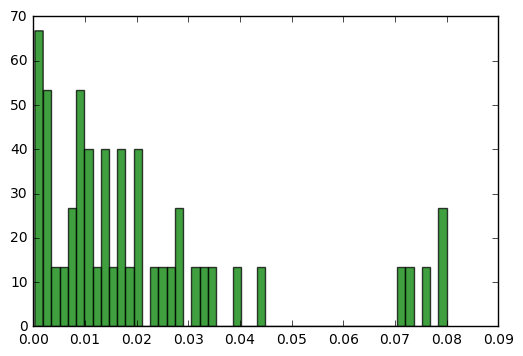

In [171]:
import matplotlib.pyplot as plt
# the histogram of the data
fin_decent_wgts = list(dfcomp.loc[dfcomp[dfcomp.weight!=0].index, 'weight'])
n, bins, patches = plt.hist(fin_decent_wgts, 50, normed=1, facecolor='g', alpha=0.75)
plt.show()

In [177]:
#contraints without minvar

from scipy.optimize import minimize

def min_dev(w):
    return sum(w-w0)**2

ind_max=0.2
co_max=0.2
w_max=0.08
w_ucits_sum = 0.38
w_ucits_one = 0.045

dfd = pd.read_csv(dloc + '04_Deka_Europe_Multi_Factor_weights_capped.csv', sep=';')
dfd['Date'] = pd.to_datetime(dfd['Date'], format='%Y-%m-%d', dayfirst=True)

dfd['ICB_ind'] = dfd['ICB_ind'].fillna(0)

#dfd = dfd[dfd.Date=='2004-03-22'].copy()

dfres = pd.DataFrame()
for d in dfd['Date'].drop_duplicates():

    dx = str(d)[:10]
    print(dx)

    dfcomp = dfd[(dfd.Date==d) & -(dfd.weight.isnull())].reset_index(drop=True)
    
    n = len(dfcomp)
    b_ = [(0., w_max) for i in range(n)]
    
    cons = np.array([])
    cons = np.append(cons, {'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    
    #industry constraints
    #https://stackoverflow.com/questions/45491376/scipy-optimization-not-running-when-i-try-to-set-constraints-using-a-for-loop/45493887#45493887
    industryidx=list()
    for i in np.unique(list(dfcomp.ICB_ind)):
        industryidx.append(dfcomp[dfcomp.ICB_ind==i]['isin'].index)
    
    for ind in range(len(industryidx)):
        con ={'type':'ineq', 'fun': lambda w, ind=ind: ind_max - sum(w[industryidx[ind]])}
        cons = np.append(cons, con)
    
    #country constraint
    countryidx=list()
    for co in np.unique(list(dfcomp.country)):
        countryidx.append(dfcomp[dfcomp.country==co]['isin'].index)
    
    for cntry in range(len(countryidx)):
        con ={'type':'ineq', 'fun': lambda w, cntry=cntry: co_max - sum(w[countryidx[cntry]])}
        cons = np.append(cons, con)

    #ucits constraint
    cons = np.append(cons, {'type': 'ineq', 'fun': lambda w: w_ucits_sum - sum(w[w>w_ucits_one])})
    
    w0 = np.array(dfcomp['weight'])

    optiwgts = minimize(min_dev, w0, method='SLSQP', bounds=b_, constraints=cons)
    
    dfcomp['weight'] = optiwgts.x
    dfcomp.loc[dfcomp[dfcomp.weight<1e-06].index, 'weight'] = 0
    dfcomp = dfcomp.sort_values('weight', ascending=False)
    
    dfres = pd.concat([dfres,dfcomp])
    
    print(dfcomp.groupby('ICB_ind_name').sum()['weight'].sort_values(ascending=False).head())
    print(dfcomp.groupby('country').sum()['weight'].sort_values(ascending=False).head())
    print(dfcomp.loc[dfcomp[dfcomp.weight!=0].index, ['isin','weight']].sort_values('weight', ascending=False).head(10))
    print(optiwgts.x[optiwgts.x>w_ucits_one].sum(), 'sum ucits')
    print('--------------------------------------------------------------------')

dfres.reset_index(drop=True).to_csv(dloc + 'minvar/deka_ucits.csv',sep=';')
print('done')

2004-03-22
ICB_ind_name
Technology           0.200000
Financials           0.185439
Industrials          0.158251
Consumer Services    0.152471
Basic Materials      0.122936
Name: weight, dtype: float64
country
DE    0.200000
FR    0.195549
NL    0.131167
FI    0.066564
IT    0.063721
Name: weight, dtype: float64
            isin    weight
0   DE0005752000  0.051453
3   GRS419003009  0.036607
5   NL0000379121  0.031888
4   NL0000354934  0.031791
6   FR0000120529  0.031665
1   DE0007100000  0.031536
7   CH0012138605  0.030499
8   IT0000082963  0.030385
9   FR0000054900  0.030131
12  DK0010268606  0.028074
0.051453388525 sum ucits
--------------------------------------------------------------------
2004-06-21
ICB_ind_name
Industrials          0.200000
Technology           0.167536
Financials           0.154046
Consumer Services    0.141780
Health Care          0.105810
Name: weight, dtype: float64
country
DE    0.144462
CH    0.129038
NL    0.124471
FI    0.118766
IT    0.105245
Name: we

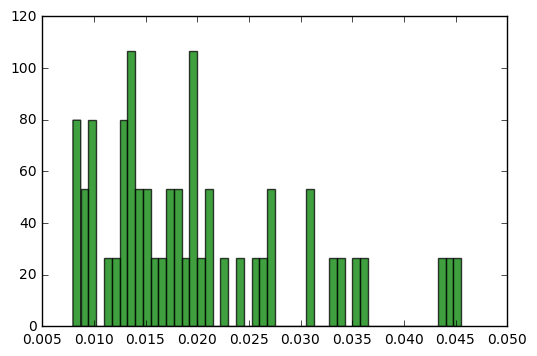

In [17]:
import matplotlib.pyplot as plt
# the histogram of the data
fin_decent_wgts = list(dfcomp.loc[dfcomp[dfcomp.weight!=0].index, 'weight'])
n, bins, patches = plt.hist(fin_decent_wgts, 50, normed=1, facecolor='g', alpha=0.75)
plt.show()